# YOLO

## LabelImg

[LabelImg Github](https://github.com/heartexlabs/labelImg)

安裝方式: pip install labelimg

輸出選擇 yolo format, 存放在跟你的圖片同一個資料夾即可

## YOLO介紹

### 物件偵測歷史

以前的時候, 是把偵測物件的位置和分類任務當成兩個網路進行(e.g.RCNN), YOLO把偵測物體的位置和分類一起執行, 所以可以加速偵測的任務

### yolo網路結構

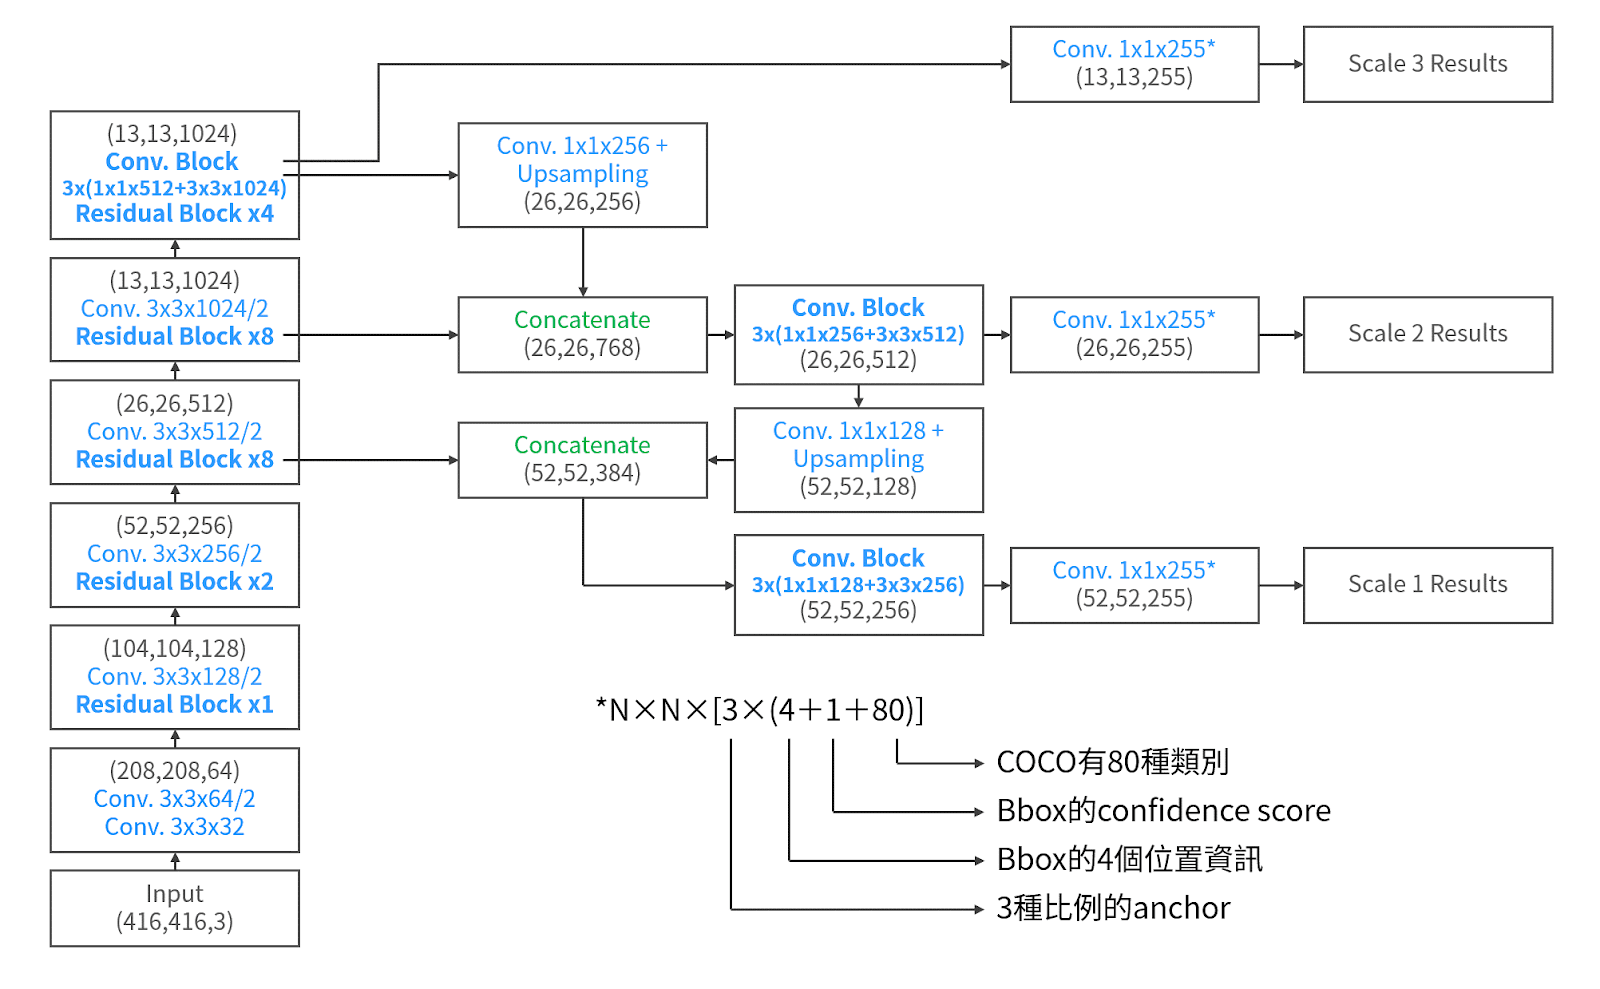

整個網路如上所述, 先使用darknet將 (416, 416, 3) 的圖片卷積成 (13, 13, 1024), 接著分出三個分支, 分別是濃縮32倍的 (13, 13, 255), 濃縮16倍(26, 26, 255) 和 濃縮8倍的 (52, 52, 255)

- 濃縮32倍: 負責偵測大型物體
- 濃縮16倍: 負責偵測中型問題
- 濃縮8倍: 負責偵測小型物體

最後為何是255呢?

yolo是一個全卷積網路, 最後的輸出分別是 

- x:中心點x y:中心點y w:框框的寬度 h:框框的高度 c:框框信心程度x
- 每個class的分別機率

上述的總共會有三份(小/中/大)三個anchor box

在COCO資料集總共有80種類別, 所以是 (5(x,y,w,h,c) + 80(class)) * 3 = 255


### NMS抑制

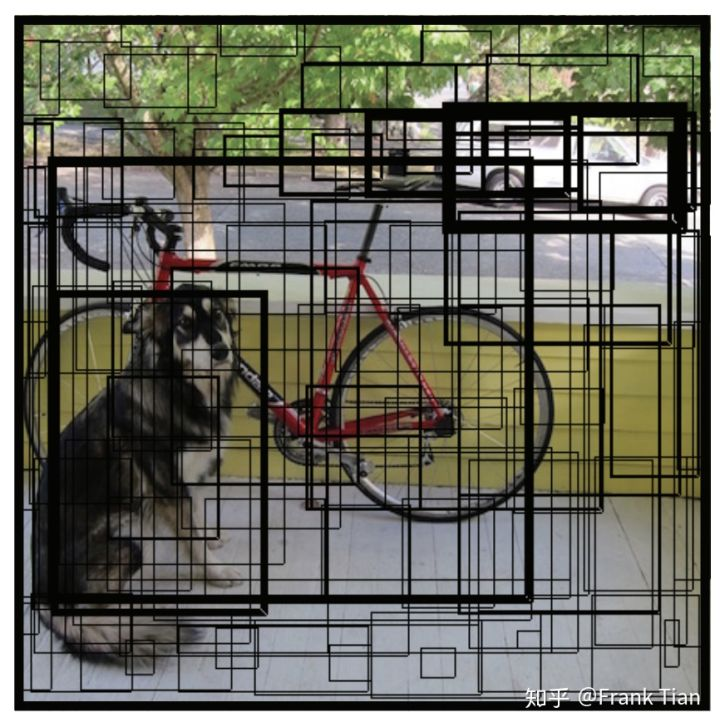

當你最後輸出多個框框的時候會選擇confidence最高的那個框, 其他人的 $ IOU = \frac{A \bigcap B}{A \bigcup B} $ 如果超過 threshold 就抑制掉

### Ground Truth 以及 Loss

- Yolo由框框正中心的grid負責預測

- Yolo給正確答案的時候比較特別, x, y, w, h　和各個 class　是固定的沒錯, 但 confidence　是根據妳目前預測的框跟正確的框做出IOU, confidence=IOU, 這裡目的是不是每個框的正確答案都是1, 如果你跟正確答案重疊的幅度沒那麼大,　那你目前的正確 confidence就不該這麼高

- Yolo的Loss如下所示, 1/2/3/5　五項是有物體的時候用, 第一第二項計算x, y, w, h的loss, 第三項是confidence的Cross Entropy,　第五項是每種class的cross entropy, 4這項則是沒物體的時候用

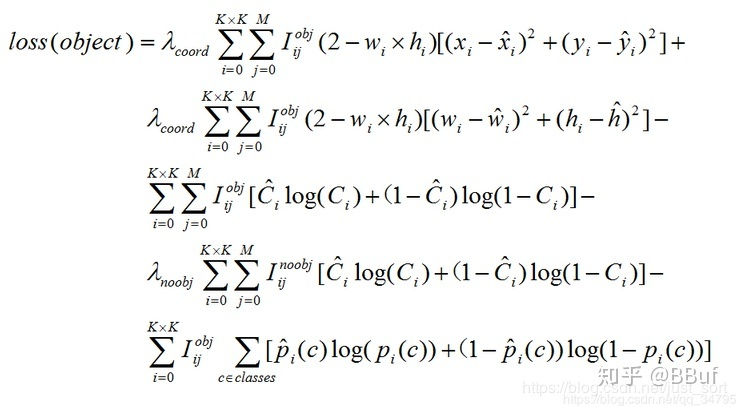


# YoloV4實作

[DarkNet Github](https://github.com/AlexeyAB/darknet)

In [ ]:
# mount drive以後把My Drive資料夾簡稱 /mydrive
!ln -s /content/drive/My\ Drive/ /mydrive

In [ ]:
#　clone darknet
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# make
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# check cuda
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# make
!make

In [ ]:
# 把資料集複製到這次的機器上
!cp /mydrive/yolov4/obj.zip ../
!unzip ../obj.zip -d data/

## custom.cfg

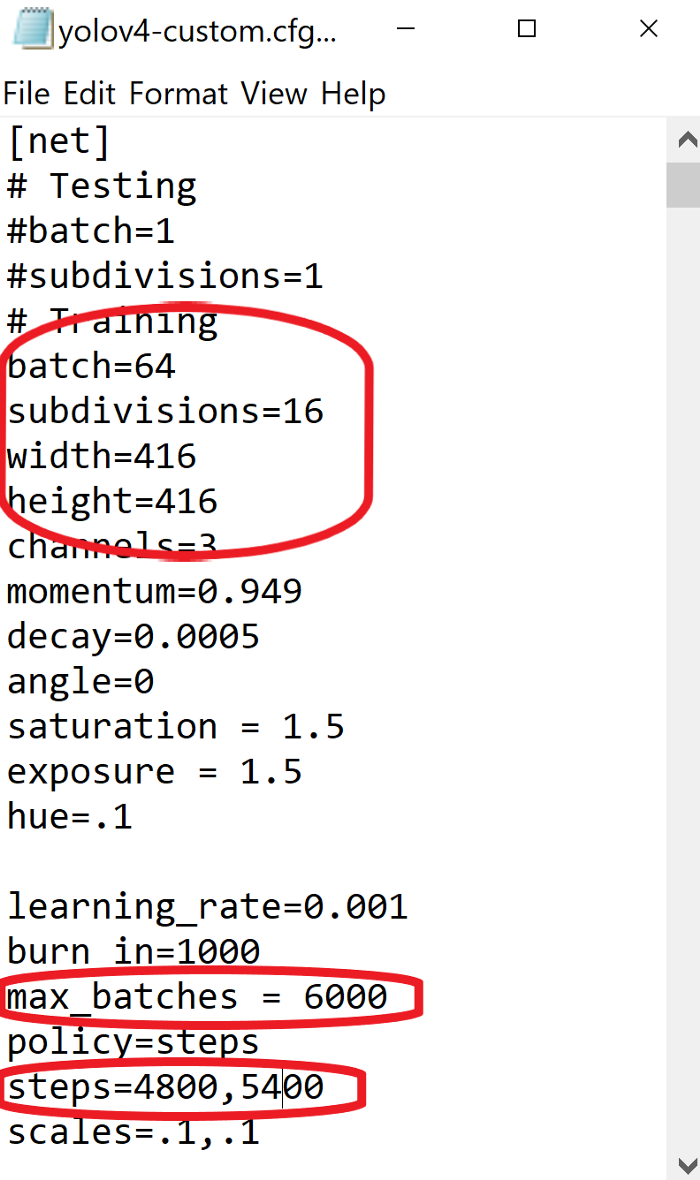

- change line batch to batch=64
- change line subdivisions to subdivisions=16
- set network size width=416 height=416 or any value multiple of 32
- change line max_batches to (classes*2000 but not less than the number of - training images and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
- change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400


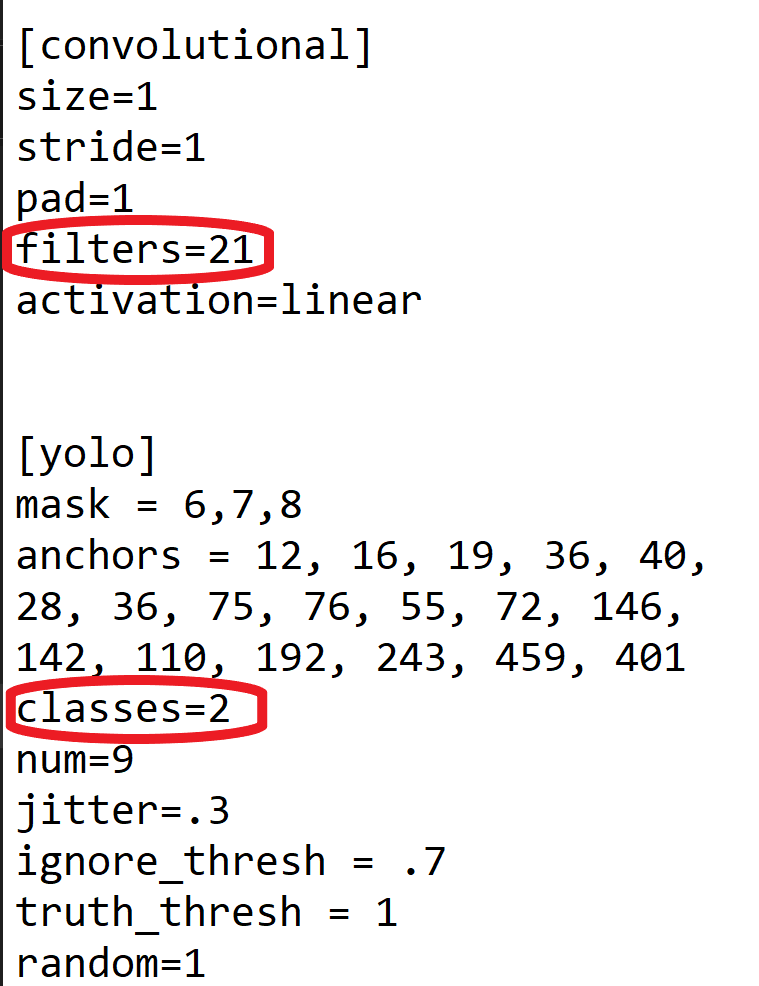

- change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.
- change line classes=80 to your number of objects in each of 3 [yolo]-layers.

In [ ]:
# 複製cfg到本地端
!cp /mydrive/yolov4/yolov4-custom.cfg ./cfg

In [ ]:
# 複製obg.names和obj.data到本地端
!cp /mydrive/yolov4/obj.names ./data
!cp /mydrive/yolov4/obj.data ./data

In [ ]:
# 分出train.txt和test.txt
!cp /mydrive/yolov4/process.py ./

In [ ]:
!python process.py

/content/darknet


In [ ]:
# 下載weeight
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
# 第一次訓練用這個
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# 第二次以後用這個
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights -dont_show -map

串流輸出內容已截斷至最後 5000 行。
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.714508), count: 14, class_loss = 2.104686, iou_loss = 1.840097, total_loss = 3.944783 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.751475), count: 19, class_loss = 1.187459, iou_loss = 0.590647, total_loss = 1.778107 
 total_bbox = 550417, rewritten_bbox = 0.212748 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.000000), count: 1, class_loss = 0.000003, iou_loss = 0.000000, total_loss = 0.000003 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.852687), count: 1, class_loss = 0.113727, iou_loss = 0.115061, total_loss = 0.228788 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.792591), count: 12, class_loss = 0.394495, iou_loss = 0.295992, total_loss = 0.690487 
 total_bbox = 550430, rewritten_bbox = 0.212743 % 
v3 (iou loss, Normalizer: (io

In [ ]:
# 訓練到最後會有yolov4-custom_best.weights, 用它來預測, 你可以使用threshold來決定多少confidence算
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_best.weights /mydrive/yolov4/test/529.jpg -thresh 0.5

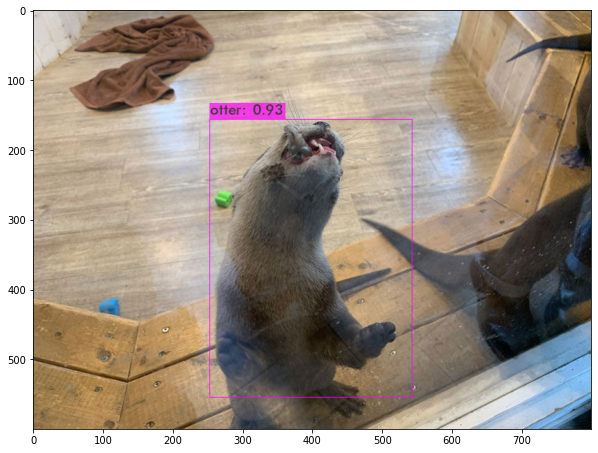

In [ ]:
# 圖會產生在predictions.jpg
from PIL import Image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
img = Image.open("predictions.jpg")
plt.imshow(img)

yolo (1).png

## mAP

[補充資料](http://yy-programer.blogspot.com/2020/06/iouapmap.html)